In [5]:
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
input_reg = pd.read_csv("/content/drive/MyDrive/reg_feat2.csv", index_col = None, encoding="CP949")
output_reg = pd.read_csv("/content/drive/MyDrive/reg_output2.csv", index_col = None, encoding="CP949")
input_std = pd.read_csv("/content/drive/MyDrive/input_std.csv", index_col = None, encoding="CP949")
output_std = pd.read_csv("/content/drive/MyDrive/output_norm.csv", index_col = None, encoding="CP949")
input_std2 = pd.read_csv("/content/drive/MyDrive/input_after.csv", index_col = None, encoding="CP949")
output_std2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/output_extends.csv", index_col = None, encoding="CP949")



In [8]:
#데이터 불러와 input과 output 설정
output = output_std2['3'].values
input = input_std2.values     

In [9]:
output = output * 10

In [11]:
real_input = input_std.values

In [12]:
real_output = output_std['3'].values
real_output = real_output * 10

In [13]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.losses import MeanAbsolutePercentageError 
from keras.callbacks import Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

In [14]:
#Train Set과 Test Set 설정
X_train, X_test, y_train, y_test = train_test_split(input,output, test_size=0.2, random_state=41)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3144, 15) (3144,)
(786, 15) (786,)


In [30]:
#define model
def build_model():
  model = Sequential()
  model.add(Dense(512, activation = 'relu',input_dim=15))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
  return model


In [31]:
model2 = build_model()

In [32]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [33]:
early_stop = EarlyStopping(monitor='mae', patience=50)

In [ ]:
#모델 학습
EPOCHS = 200

history = model2.fit(X_train, y_train, epochs=EPOCHS,
                    validation_data=(X_test, y_test), verbose=1, batch_size=1, callbacks=[early_stop]
)

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,val_loss,val_mae,epoch
195,0.021326,0.112014,0.026417,0.117460,195
196,0.021645,0.112400,0.025785,0.121546,196
197,0.020882,0.110742,0.028219,0.121520,197
198,0.021334,0.111551,0.025450,0.118027,198
199,0.021107,0.111305,0.026482,0.120492,199


In [ ]:
#k-fold cross validation
k = 4
num_val_samples = len(input) // k
num_epochs = 1000
all_mae_histories = []
for i in range(k):
  print('처리중인 폴드 #', i)
  val_data = input[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = output[i * num_val_samples:(i+1)*num_val_samples]

  partial_train_data = np.concatenate([input[:i*num_val_samples],
                                       input[(i+1)*num_val_samples:]],
                                      axis=0)
  
  partial_train_targets = np.concatenate(
      [output[:i*num_val_samples], output[(i+1) * num_val_samples:]],
      axis = 0)
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, validation_data = (val_data, val_targets), epochs = num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

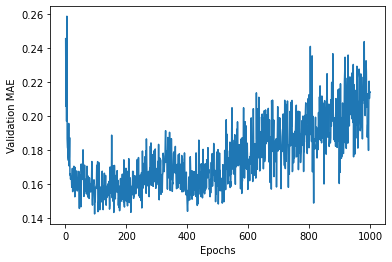

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

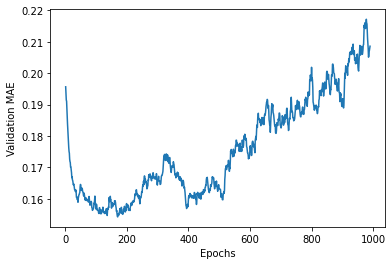

In [ ]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

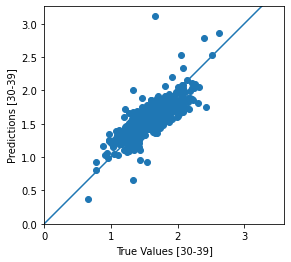

In [37]:
#학습결과 도식화
test_predictions = model2.predict(X_test).flatten()
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [30-39]')
plt.ylabel('Predictions [30-39]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-1000, 1000], [-1000, 1000])

Text(0.5, 0, 'Prediction Error')

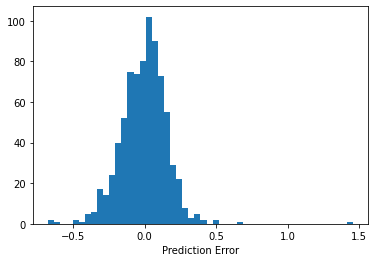

In [38]:
error = test_predictions - y_test
plt.hist(error, bins=50)
plt.xlabel("Prediction Error")

In [ ]:
for layer in model2.layers:
  weights = layer.get_weights()
  print(weights)

In [ ]:
model2.save('/content/drive/MyDrive/Colab Notebooks/80model.h5')

In [40]:
#확장되기 전의 실 데이터에 적용
real = model2.predict(real_input)

In [41]:
real_minus = np.subtract(real,real_output)
real_abs = np.abs(real_minus)
error = np.divide(real_abs, real_output)*100


In [44]:
np.mean(error)

21.705659472804157

In [45]:
#lightGBM
from lightgbm import LGBMClassifier, plot_importance
from sklearn import preprocessing
from sklearn import utils

In [47]:
lab_enc = preprocessing.LabelEncoder()
test_scores_encoded = lab_enc.fit_transform(y_test)
print(training_scores_encoded)
print(utils.multiclass.type_of_target(y_test))
print(utils.multiclass.type_of_target(y_test.astype('int')))
print(utils.multiclass.type_of_target(y_test))

[1206 1116 2014 ...  689 2496 2186]
continuous
multiclass
continuous


In [50]:
lgb = LGBMClassifier(n_estimators=10, max_depth=5)
evals = [(X_test, test_scores_encoded)]
lgb.fit(X_train, training_scores_encoded, early_stopping_rounds = 100, eval_metric = 'logloss', eval_set = evals, verbose = True)


[1]	valid_0's multi_logloss: 10.3007	valid_0's multi_logloss: 10.3007
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 18.4479	valid_0's multi_logloss: 18.4479
[3]	valid_0's multi_logloss: 30.8267	valid_0's multi_logloss: 30.8267
[4]	valid_0's multi_logloss: 33.264	valid_0's multi_logloss: 33.264
[5]	valid_0's multi_logloss: 33.8359	valid_0's multi_logloss: 33.8359
[6]	valid_0's multi_logloss: 34.343	valid_0's multi_logloss: 34.343
[7]	valid_0's multi_logloss: 34.4672	valid_0's multi_logloss: 34.4672
[8]	valid_0's multi_logloss: 34.4781	valid_0's multi_logloss: 34.4781
[9]	valid_0's multi_logloss: 34.5226	valid_0's multi_logloss: 34.5226
[10]	valid_0's multi_logloss: 34.5209	valid_0's multi_logloss: 34.5209
Did not meet early stopping. Best iteration is:
[1]	valid_0's multi_logloss: 10.3007	valid_0's multi_logloss: 10.3007


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

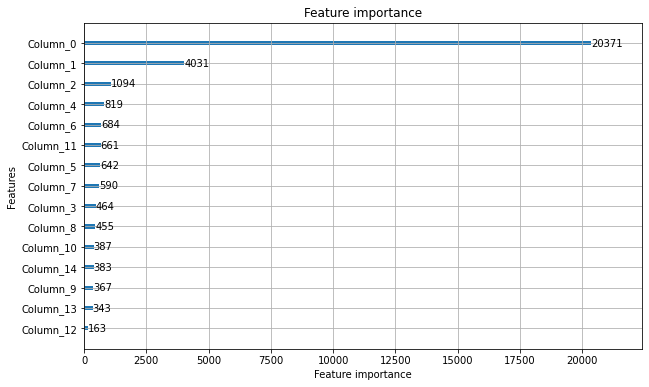

In [51]:
fig, ax = plt.subplots(figsize = (10,6))
plot_importance(lgb, ax = ax)